# 📒 Notebook : Text Classification on Mail


### 📨 Context

If you are working, then you are bound to face the problem of reading all the emails that are cluttered in your inbox.  
Some may be relevant and some may just try to loot you.

Now, our client is an editor for a major newspaper who is fed up with reading the emails that his/her journalists send and manually categorizing them.  
So let's make their life a little easier.


The dataset **"Topic Modelling on Emails"**, provided by **Dipankar Srirag** on Kaggle, is designed for **text classification** and **topic modeling** tasks. It contains email exchanges between journalists, organized into folders that represent their respective categories. Each folder includes **unstructured text files**, with each file representing an individual email.

---

## 📁 Dataset Structure

- **Organization**:  
  The emails are grouped into folders named after their categories, which makes the dataset well-suited for supervised text classification tasks.  
  Inconvenient : some texts are in several groups which need to be revised 

- **Content**:  
  Each `.txt` file contains one individual email in raw, unstructured format.

---

🔗 **Dataset Link**:  
[Topic Modelling on Emails – Kaggle](https://www.kaggle.com/datasets/dipankarsrirag/topic-modelling-on-emails)


In [1]:
## You can use here kagglehub api
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("dipankarsrirag/topic-modelling-on-emails")

# print("Path to dataset files:", path)

In [2]:
# Import of necessary packages
import os
import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

import gensim
import gensim.downloader as api
from gensim.models import Word2Vec, KeyedVectors

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
from sklearn.manifold import TSNE



## Data Preparation

The email texts are organized in **folders**, where each folder name represents a category or topic.

To work efficiently with this dataset, we'll need to:

- Traverse the directory structure
- Read each text file
- Assign a label based on the folder it comes from
- Build a **DataFrame** with appropriate columns:  
  `text` (the email content) and `label` (the folder/category name)

This preprocessing step is essential before applying any classification or topic modeling techniques.


In [3]:
# Use the data from the folder
path= "./"

In [4]:
folder = os.listdir(path+"\Data")

Here are the labels  

In [5]:
folder


['Crime', 'Entertainment', 'Politics', 'Science']

In [6]:
# create a DataFrame from the data
df = pd.DataFrame(columns=["name", "text", "label"])
for category in folder:
    path_to_files = os.path.join(path, "Data", category)
    print("Reading file:", path_to_files) # Debugging line to check path
    
    for file in os.listdir(path_to_files):
        if file.endswith(".txt"):
            with open(os.path.join(path_to_files, file), 'r', encoding='latin1') as f: # Use 'latin1' encoding to handle special characters
                # Read the file and append to DataFrame
                text = f.read()
                df.loc[len(df)] = [file, text, category]

Reading file: ./Data\Crime
Reading file: ./Data\Entertainment
Reading file: ./Data\Politics
Reading file: ./Data\Science


In [7]:
df

,name,text,label
0,14147.txt,"\nArchive-name: ripem/faq\nLast-update: Sun, 7...",Crime
1,14831.txt,Approved: news-answers-request@MIT.EDU\nConten...,Crime
2,14832.txt,Approved: news-answers-request@MIT.EDU\nConten...,Crime
3,14982.txt,Message-ID: <1ppvai$l79@bilbo.suite.com>\nRepl...,Crime
4,14983.txt,\n Some sick part of me really liked that ph...,Crime
...,...,...,...
9148,62615.txt,Distribution: world\nMessage-ID: <cshotton-180...,Science
9149,62616.txt,\nJeffrey L. Cook sez;\n>>This object would no...,Science
9150,62708.txt,Message-ID: <1tdqmvINN3q2@hp-col.col.hp.com>\n...,Science
9151,62709.txt,Message-ID: <1t6dd1$11v@network.ucsd.edu>\nRef...,Science


In [8]:
df["text"][0]

'\nArchive-name: ripem/faq\nLast-update: Sun, 7 Mar 93 21:00:00 -0500\n\nABOUT THIS POSTING\n------------------\nThis is a (still rather rough) listing of likely questions and\ninformation about RIPEM, a program for public key mail encryption.  It\n(this FAQ, not RIPEM) was written and will be maintained by Marc\nVanHeyningen, <mvanheyn@whale.cs.indiana.edu>.  It will be posted to a\nvariety of newsgroups on a monthly basis; follow-up discussion specific\nto RIPEM is redirected to the group alt.security.ripem.\n\nThis month, I have reformatted this posting in an attempt to comply\nwith the standards for HyperText FAQ formatting to allow easy\nmanipulation of this document over the World Wide Web.  Let me know\nwhat you think.\n\nDISCLAIMER\n----------\nNothing in this FAQ should be considered legal advice, or anything\nother than one person\'s opinion.  If you want real legal advice, talk\nto a real lawyer.\n\nQUESTIONS AND ANSWERS\n---------------------\n\n1)  What is RIPEM?\n\n RIPEM

C:\Users\tanto\AppData\Local\Temp\ipykernel_37328\4123978739.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df["label"], palette="Set2")


<Axes: xlabel='count', ylabel='label'>

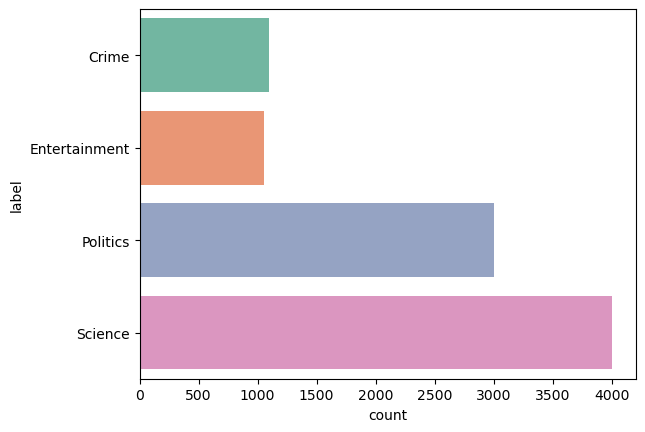

In [9]:
# Labels Distribution 
sns.countplot(df["label"], palette="Set2")


In [10]:
# Let's the duplicated texts in the labels
df[df["name"].duplicated()]

,name,text,label
1100,14147.txt,"\nArchive-name: ripem/faq\nLast-update: Sun, 7...",Entertainment
1101,14831.txt,Approved: news-answers-request@MIT.EDU\nConten...,Entertainment
1102,14832.txt,Approved: news-answers-request@MIT.EDU\nConten...,Entertainment
1103,14982.txt,Message-ID: <1ppvai$l79@bilbo.suite.com>\nRepl...,Entertainment
1104,14983.txt,\n Some sick part of me really liked that ph...,Entertainment
...,...,...,...
7148,54499.txt,\nIn article <1993Apr27.152314.28798@donau.et....,Science
7149,54500.txt,\nFiberglass boards are available in several c...,Science
7150,54501.txt,\nIn article <sehari.735962071@du139-201.cc.ia...,Science
7151,54502.txt,\nIn article <bbuck.735977235@Endor> bbuck@End...,Science


In [11]:
multiple_labeled = df[df["name"].duplicated()]["name"].unique()
multiple_labeled

array(['14147.txt', '14831.txt', '14832.txt', ..., '54501.txt',
       '54502.txt', '54503.txt'], dtype=object)

In [12]:
df[df["name"] == "14831.txt"]

,name,text,label
1,14831.txt,Approved: news-answers-request@MIT.EDU\nConten...,Crime
1101,14831.txt,Approved: news-answers-request@MIT.EDU\nConten...,Entertainment
5154,14831.txt,Approved: news-answers-request@MIT.EDU\nConten...,Science


## ⚠️ Data Leakage Warning: Same Texts in Multiple Categories

Upon inspection, some email texts appear in **multiple categories** (i.e., the same content exists in different folders). This introduces a risk of:

- **Data leakage** during training/testing splits
- **Label ambiguity** during classification
- **Bias** in evaluation metrics

---

### ❌ Why Simple Solutions Don’t Work

- **Removing duplicates** entirely would result in a **significant loss of data**, which is problematic given that the dataset is already **highly imbalanced**.
- **Manual review and reclassification** is not feasible due to the dataset's size and low return on time investment.

---


##  Simple Heuristic-Based Classification by Keyword Presence

To mitigate the issue of duplicate texts across multiple categories — and to reduce noise — we can adopt a **keyword-based classification strategy**:

### Intuition

If a duplicated text shares a high overlap of **important words** (i.e., frequent, discriminative terms) with a text that belongs to a **unique category**, we can **infer the most probable category** for the ambiguous text. Otherwise, we proceed context similarity given by the lexical group

---

###  Benefits

- Doesn't require manual annotation.
- Preserves more data than strict deduplication.
- Reduces the impact of ambiguous labeling due to overlapping files.

---

### Limitations

- Still heuristic: might misclassify if keywords are shared across categories.
- Works best if each category has **distinctive vocabulary**.


In [13]:

stop_words = set(stopwords.words('english'))

def tokenize_text(text):
    words = word_tokenize(text)
    return words

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\S+@\S+", "", text)
    text = re.sub(r"In article <.*?>.*?writes:\n?", "", text)
    text = re.sub(r"(?m)^> ?", "", text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = tokenize_text(text)
    words = [w for w in words if w not in stop_words and (len(w) > 2)]
    return " ".join(words)

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = tokenize_text(text)
    words = [lemmatizer.lemmatize(w) for w in words]
    return " ".join(words)


def plot_word_counts(df, label):
    word_counts = Counter(" ".join(df[df["label"]==label]["clean_text"]).split())
    common_words = word_counts.most_common(20)
    
    words, freqs = zip(*common_words)
    plt.figure(figsize=(6, 6))
    sns.barplot(x=list(freqs), y=list(words))
    plt.title(f"Most Common Words in {label} Category")
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.yticks(rotation=25)
    plt.tight_layout()
    plt.show()


def doc_vector(doc_tokens, model):
    vectors = [model.wv[word] for word in doc_tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)



In [14]:
df["removed_text"] = df.apply(lambda x: clean_text(x["text"]), axis=1)
df["clean_text"] = df.apply(lambda x: lemmatize_text(x["removed_text"]), axis=1)
df["tokenized_text"] = df.apply(lambda x: tokenize_text(x["clean_text"]), axis=1)


In [15]:
df.head()

,name,text,label,removed_text,clean_text,tokenized_text
0,14147.txt,"\nArchive-name: ripem/faq\nLast-update: Sun, 7...",Crime,archive name ripem faq last update sun mar pos...,archive name ripem faq last update sun mar pos...,"[archive, name, ripem, faq, last, update, sun,..."
1,14831.txt,Approved: news-answers-request@MIT.EDU\nConten...,Crime,approved content type text usenet faq version ...,approved content type text usenet faq version ...,"[approved, content, type, text, usenet, faq, v..."
2,14832.txt,Approved: news-answers-request@MIT.EDU\nConten...,Crime,approved content type text usenet faq version ...,approved content type text usenet faq version ...,"[approved, content, type, text, usenet, faq, v..."
3,14982.txt,Message-ID: <1ppvai$l79@bilbo.suite.com>\nRepl...,Crime,message reply nntp posting host nimrod suite c...,message reply nntp posting host nimrod suite c...,"[message, reply, nntp, posting, host, nimrod, ..."
4,14983.txt,\n Some sick part of me really liked that ph...,Crime,sick part really liked phrase actually merely ...,sick part really liked phrase actually merely ...,"[sick, part, really, liked, phrase, actually, ..."


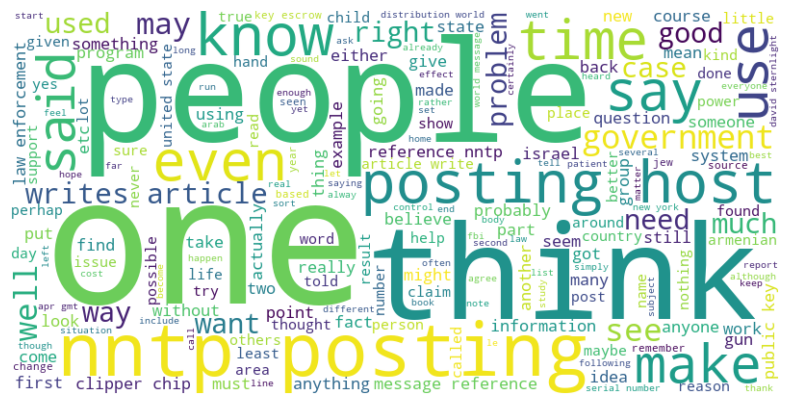

In [16]:

text = " ".join(df["clean_text"])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [17]:
df1 = df[~df["name"].isin(multiple_labeled)]
df2 = df[df["name"].isin(multiple_labeled)]

In [18]:
df1

,name,text,label,removed_text,clean_text,tokenized_text
2153,124146.txt,Nntp-Posting-Host: acvax1\nNntp-Posting-User: ...,Politics,nntp posting host acvax nntp posting user cvad...,nntp posting host acvax nntp posting user cvad...,"[nntp, posting, host, acvax, nntp, posting, us..."
2154,176845.txt,\nIn <C4v13w.Dup@apollo.hp.com> nelson_p@apoll...,Politics,peter nelson writes article bob blackshaw writ...,peter nelson writes article bob blackshaw writ...,"[peter, nelson, writes, article, bob, blacksha..."
2155,176846.txt,NNTP-Posting-Host: oregon.uoregon.edu\nNews-So...,Politics,nntp posting host oregon uoregon edu news soft...,nntp posting host oregon uoregon edu news soft...,"[nntp, posting, host, oregon, uoregon, edu, ne..."
2156,176847.txt,NNTP-Posting-Host: oregon.uoregon.edu\nNews-So...,Politics,nntp posting host oregon uoregon edu news soft...,nntp posting host oregon uoregon edu news soft...,"[nntp, posting, host, oregon, uoregon, edu, ne..."
2157,176849.txt,NNTP-Posting-Host: oregon.uoregon.edu\nNews-So...,Politics,nntp posting host oregon uoregon edu news soft...,nntp posting host oregon uoregon edu news soft...,"[nntp, posting, host, oregon, uoregon, edu, ne..."
...,...,...,...,...,...,...
9148,62615.txt,Distribution: world\nMessage-ID: <cshotton-180...,Science,distribution world message references nntp pos...,distribution world message reference nntp post...,"[distribution, world, message, reference, nntp..."
9149,62616.txt,\nJeffrey L. Cook sez;\n>>This object would no...,Science,jeffrey cook sez object would interfere anyone...,jeffrey cook sez object would interfere anyone...,"[jeffrey, cook, sez, object, would, interfere,..."
9150,62708.txt,Message-ID: <1tdqmvINN3q2@hp-col.col.hp.com>\n...,Science,message references nntp posting host hpctdkz c...,message reference nntp posting host hpctdkz co...,"[message, reference, nntp, posting, host, hpct..."
9151,62709.txt,Message-ID: <1t6dd1$11v@network.ucsd.edu>\nRef...,Science,message references nntp posting host lyapunov ...,message reference nntp posting host lyapunov u...,"[message, reference, nntp, posting, host, lyap..."


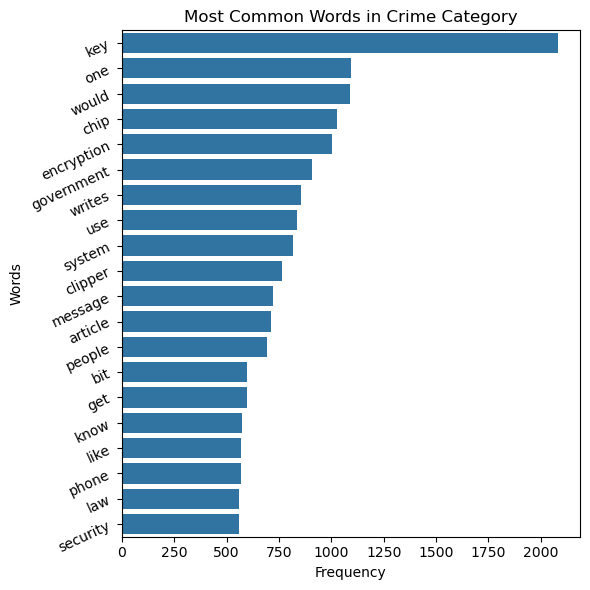

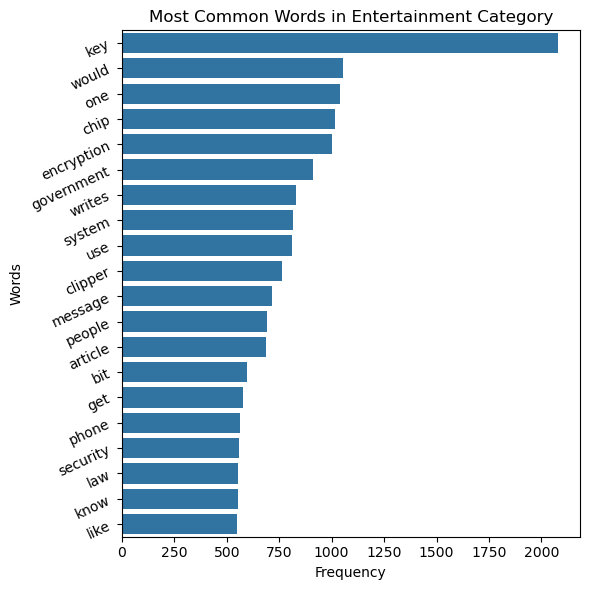

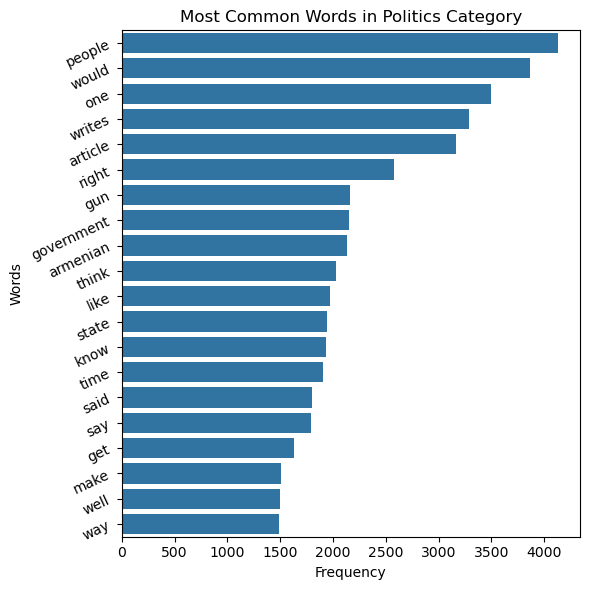

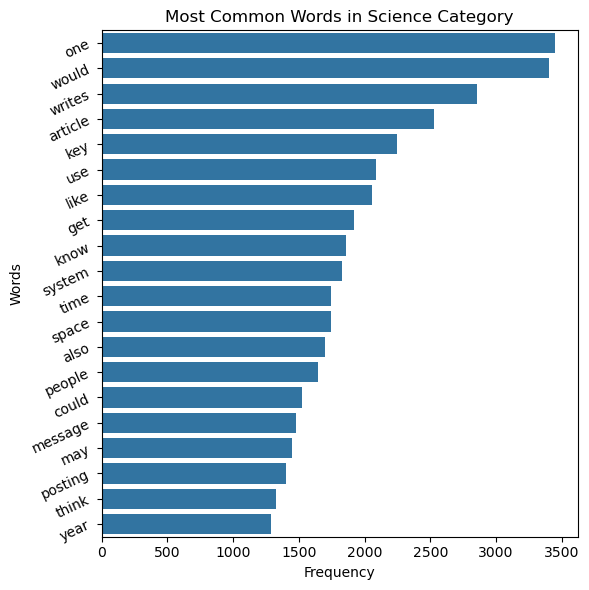

In [19]:
for label in df["label"].unique():
    plot_word_counts(df, label)


In [20]:
df1["label"].unique()

array(['Politics', 'Science'], dtype=object)

In [21]:
df[df["name"].isin(multiple_labeled)]["text"][20]

"Weather: mostly cloudy, high 64, low 49\nMoon-Phase: waxing gibbous (99% of full)\n\nIn article <1993Apr2.050451.7866@ucsu.Colorado.EDU> cuffell@spot.Colorado.EDU\n(Tim Cuffel) writes:\n>How about this.  I create a bunch of sets of random data, and encrypt it.  I \n>keep only one of the sets of random data around, to show that I encypt random\n>data for kicks.  The rest, I delete with their keys.  I tell all my friends.\n>I think this establishes reasonable doubt about the contents of any encrypted\n>files, and my ability to provides keys.  Since anyone could do this, any law\n>that forces a user to provide keys on demand is worthless.\n\nThe law is much worse than worthless.  It gives police the power to put\ninnocent people in jail because they (the police) find something they don't\nunderstand.  Most police don't know what the return key does, never mind the\ndifference between a core file and classified military secrets.\n\nThere are plenty of scenarios where the user would have n

In [22]:
multiple_labeled

array(['14147.txt', '14831.txt', '14832.txt', ..., '54501.txt',
       '54502.txt', '54503.txt'], dtype=object)

In [23]:
# If you don't want to download the weight model, you can use the api
# However the training is not possible with
# model = api.load("word2vec-google-news-300") 
model = KeyedVectors.load_word2vec_format(
    'GoogleNews-vectors-negative300.bin',
    binary=True
)



In [24]:
# We want to detect the empty list
ak = df["tokenized_text"].apply(lambda x: len(x))

In [25]:
ak.min(), ak.max(), ak.mean(), ak.std()

(0, 6224, 159.4660766961652, 302.55339674162695)

In [26]:
np.where(ak == 0)

(array([ 243,  677,  881, 1343, 1777, 1981, 3574, 3575, 4253, 4255, 4363,
        4379, 4423, 4444, 4742, 5396, 5830, 6034, 6488, 7028, 7174, 7175,
        7279, 7303, 7342, 7345, 7504, 7511, 7563, 7880, 8072, 8073, 8147,
        8256, 8808, 8893], dtype=int64),)

In [27]:
drop_empty = (np.where(ak == 0))[0].tolist()

In [28]:
# drop them
df.drop(drop_empty, inplace=True, axis=0)    

In [29]:

# load weights
pretrained = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)


In [30]:
# On construit un modèle Word2Vec avec la même architecture
model = Word2Vec(vector_size=300, min_count=2, window=5)

# On initialise le vocabulaire avec tes données
model.build_vocab(df["tokenized_text"])

# Puis on met à jour le vocabulaire avec celui du modèle pré-entraîné
model.build_vocab([list(pretrained.key_to_index.keys())], update=True)

# On copie les vecteurs pré-entraînés
model.wv.vectors_lockf = np.ones(len(model.wv), dtype=np.float32)
model.wv.intersect_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, lockf=1.0)


In [31]:
# Entraînement sur tes données
model.train(df["tokenized_text"], total_examples=len(df["tokenized_text"]), epochs=5, )


(7105399, 7297965)

In [33]:
vec = model.wv['crime']
print(vec.shape)  # (100,)


(300,)


In [34]:
print(model.wv.most_similar('ripem'))


[('pem', 0.694535493850708), ('pgp', 0.6434460282325745), ('rfcs', 0.5872368216514587), ('rsaref', 0.5848371982574463), ('version', 0.5457609295845032), ('unix', 0.5454891324043274), ('vanheyningen', 0.542576014995575), ('rsa', 0.5417863726615906), ('server', 0.5156144499778748), ('deallocation', 0.5079429149627686)]


In [35]:
doc_vecs = [doc_vector(doc_tokens, model) for doc_tokens in df["tokenized_text"]]
doc_vecs = np.array(doc_vecs)


In [36]:
doc_vecs.shape

(9117, 300)

In [37]:
df

,name,text,label,removed_text,clean_text,tokenized_text
0,14147.txt,"\nArchive-name: ripem/faq\nLast-update: Sun, 7...",Crime,archive name ripem faq last update sun mar pos...,archive name ripem faq last update sun mar pos...,"[archive, name, ripem, faq, last, update, sun,..."
1,14831.txt,Approved: news-answers-request@MIT.EDU\nConten...,Crime,approved content type text usenet faq version ...,approved content type text usenet faq version ...,"[approved, content, type, text, usenet, faq, v..."
2,14832.txt,Approved: news-answers-request@MIT.EDU\nConten...,Crime,approved content type text usenet faq version ...,approved content type text usenet faq version ...,"[approved, content, type, text, usenet, faq, v..."
3,14982.txt,Message-ID: <1ppvai$l79@bilbo.suite.com>\nRepl...,Crime,message reply nntp posting host nimrod suite c...,message reply nntp posting host nimrod suite c...,"[message, reply, nntp, posting, host, nimrod, ..."
4,14983.txt,\n Some sick part of me really liked that ph...,Crime,sick part really liked phrase actually merely ...,sick part really liked phrase actually merely ...,"[sick, part, really, liked, phrase, actually, ..."
...,...,...,...,...,...,...
9148,62615.txt,Distribution: world\nMessage-ID: <cshotton-180...,Science,distribution world message references nntp pos...,distribution world message reference nntp post...,"[distribution, world, message, reference, nntp..."
9149,62616.txt,\nJeffrey L. Cook sez;\n>>This object would no...,Science,jeffrey cook sez object would interfere anyone...,jeffrey cook sez object would interfere anyone...,"[jeffrey, cook, sez, object, would, interfere,..."
9150,62708.txt,Message-ID: <1tdqmvINN3q2@hp-col.col.hp.com>\n...,Science,message references nntp posting host hpctdkz c...,message reference nntp posting host hpctdkz co...,"[message, reference, nntp, posting, host, hpct..."
9151,62709.txt,Message-ID: <1t6dd1$11v@network.ucsd.edu>\nRef...,Science,message references nntp posting host lyapunov ...,message reference nntp posting host lyapunov u...,"[message, reference, nntp, posting, host, lyap..."


In [38]:
df.describe()

,name,text,label,removed_text,clean_text,tokenized_text
count,9117,9117,9117,9117,9117,9117
unique,6704,6844,4,6834,6834,6834
top,14147.txt,\nHere are two quotes from the White House.\n\...,Science,two quotes white house administration saying s...,two quote white house administration saying si...,"[two, quote, white, house, administration, say..."
freq,3,9,3979,9,9,9


In [40]:
model.wv.cosine_similarities(doc_vecs[9114].reshape(-1,1), doc_vecs[9113].reshape(-1,1).T)

array([[0.7718652]], dtype=float32)

In [41]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(doc_vecs)

In [42]:
# df1 is a no-duplicated-data Dataframe
df1 = df[~df["name"].isin(multiple_labeled)]

df2 = df[df["name"].isin(multiple_labeled)]

C:\Users\tanto\AppData\Local\Temp\ipykernel_37328\691904622.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df1["label"], palette="Set2")


<Axes: xlabel='count', ylabel='label'>

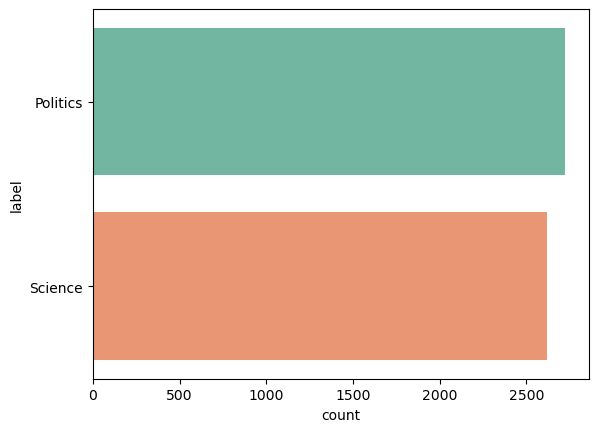

In [43]:
sns.countplot(df1["label"], palette="Set2")


In [44]:
model.wv.cosine_similarities(X_scaled[9115].reshape(-1,1), X_scaled[9114].reshape(-1,1).T)

array([[0.49966222]], dtype=float32)

In [45]:
X_scaled

array([[ 1.154208  , -1.3565898 , -0.30953145, ..., -1.3920543 ,
        -1.1741016 ,  1.3039972 ],
       [ 0.84693676, -1.2796023 , -0.04616031, ..., -1.2692101 ,
        -1.1136329 ,  1.521687  ],
       [ 1.4724152 , -0.7948327 , -0.34265265, ..., -1.9327539 ,
        -1.4829005 , -0.28367648],
       ...,
       [-0.8258912 ,  1.0157353 , -1.1891135 , ..., -0.31077543,
        -0.7177955 , -0.7484189 ],
       [-0.1682316 ,  1.0114602 , -0.46229544, ...,  0.11551864,
        -0.30353093, -0.60895807],
       [ 0.8276882 ,  0.04706273,  1.0893852 , ...,  0.5648151 ,
         0.4394687 ,  0.6676379 ]], dtype=float32)

In [ ]:
cluster = AgglomerativeClustering(n_clusters=4, metric='cosine' , linkage='average', )
labels = cluster.fit_predict(X_scaled)


In [49]:
silhouette = silhouette_score(X_scaled, labels, metric='cosine')
print("Silhouette Score:", silhouette)

Silhouette Score: 0.120611064


In [50]:
df["predict"]= labels

In [51]:
pd.DataFrame(labels).value_counts()

0
0    3720
3    1958
1    1720
2    1719
Name: count, dtype: int64

In [52]:
df

,name,text,label,removed_text,clean_text,tokenized_text,predict
0,14147.txt,"\nArchive-name: ripem/faq\nLast-update: Sun, 7...",Crime,archive name ripem faq last update sun mar pos...,archive name ripem faq last update sun mar pos...,"[archive, name, ripem, faq, last, update, sun,...",3
1,14831.txt,Approved: news-answers-request@MIT.EDU\nConten...,Crime,approved content type text usenet faq version ...,approved content type text usenet faq version ...,"[approved, content, type, text, usenet, faq, v...",3
2,14832.txt,Approved: news-answers-request@MIT.EDU\nConten...,Crime,approved content type text usenet faq version ...,approved content type text usenet faq version ...,"[approved, content, type, text, usenet, faq, v...",3
3,14982.txt,Message-ID: <1ppvai$l79@bilbo.suite.com>\nRepl...,Crime,message reply nntp posting host nimrod suite c...,message reply nntp posting host nimrod suite c...,"[message, reply, nntp, posting, host, nimrod, ...",2
4,14983.txt,\n Some sick part of me really liked that ph...,Crime,sick part really liked phrase actually merely ...,sick part really liked phrase actually merely ...,"[sick, part, really, liked, phrase, actually, ...",0
...,...,...,...,...,...,...,...
9148,62615.txt,Distribution: world\nMessage-ID: <cshotton-180...,Science,distribution world message references nntp pos...,distribution world message reference nntp post...,"[distribution, world, message, reference, nntp...",0
9149,62616.txt,\nJeffrey L. Cook sez;\n>>This object would no...,Science,jeffrey cook sez object would interfere anyone...,jeffrey cook sez object would interfere anyone...,"[jeffrey, cook, sez, object, would, interfere,...",1
9150,62708.txt,Message-ID: <1tdqmvINN3q2@hp-col.col.hp.com>\n...,Science,message references nntp posting host hpctdkz c...,message reference nntp posting host hpctdkz co...,"[message, reference, nntp, posting, host, hpct...",2
9151,62709.txt,Message-ID: <1t6dd1$11v@network.ucsd.edu>\nRef...,Science,message references nntp posting host lyapunov ...,message reference nntp posting host lyapunov u...,"[message, reference, nntp, posting, host, lyap...",1


In [53]:
df[df["predict"]==0]


,name,text,label,removed_text,clean_text,tokenized_text,predict
4,14983.txt,\n Some sick part of me really liked that ph...,Crime,sick part really liked phrase actually merely ...,sick part really liked phrase actually merely ...,"[sick, part, really, liked, phrase, actually, ...",0
10,14989.txt,\nWith regard to your speculations on NSA invo...,Crime,regard speculations nsa involvement creation p...,regard speculation nsa involvement creation pk...,"[regard, speculation, nsa, involvement, creati...",0
36,15179.txt,\nIn article <1993Apr16.001321.3692@natasha.po...,Crime,article bob cain writes hope cynicism misplace...,article bob cain writes hope cynicism misplace...,"[article, bob, cain, writes, hope, cynicism, m...",0
53,15196.txt,\nI am eager to hear the legal theory behind r...,Crime,eager hear legal theory behind restricting exc...,eager hear legal theory behind restricting exc...,"[eager, hear, legal, theory, behind, restricti...",0
55,15198.txt,\nCharles Kincy (ckincy@cs.umr.edu) wrote:\n: ...,Crime,charles kincy wrote article bob cain writes ho...,charles kincy wrote article bob cain writes ho...,"[charles, kincy, wrote, article, bob, cain, wr...",0
...,...,...,...,...,...,...,...
9145,62480.txt,\nIn article <C760Dv.K75@agora.rain.com> jhart...,Science,article jim hart writes astronomers using nigh...,article jim hart writes astronomer using night...,"[article, jim, hart, writes, astronomer, using...",0
9146,62481.txt,"\nIn article <geoffmC7508L.F1K@netcom.com>, ge...",Science,article geoff miller writes article dan herrin...,article geoff miller writes article dan herrin...,"[article, geoff, miller, writes, article, dan,...",0
9147,62614.txt,Distribution: world\nMessage-ID: <18MAY1993130...,Science,distribution world message references nntp pos...,distribution world message reference nntp post...,"[distribution, world, message, reference, nntp...",0
9148,62615.txt,Distribution: world\nMessage-ID: <cshotton-180...,Science,distribution world message references nntp pos...,distribution world message reference nntp post...,"[distribution, world, message, reference, nntp...",0


In [54]:
df[(df["predict"]==0) & (df["label"]=="Politics")]

,name,text,label,removed_text,clean_text,tokenized_text,predict
2154,176845.txt,\nIn <C4v13w.Dup@apollo.hp.com> nelson_p@apoll...,Politics,peter nelson writes article bob blackshaw writ...,peter nelson writes article bob blackshaw writ...,"[peter, nelson, writes, article, bob, blacksha...",0
2155,176846.txt,NNTP-Posting-Host: oregon.uoregon.edu\nNews-So...,Politics,nntp posting host oregon uoregon edu news soft...,nntp posting host oregon uoregon edu news soft...,"[nntp, posting, host, oregon, uoregon, edu, ne...",0
2156,176847.txt,NNTP-Posting-Host: oregon.uoregon.edu\nNews-So...,Politics,nntp posting host oregon uoregon edu news soft...,nntp posting host oregon uoregon edu news soft...,"[nntp, posting, host, oregon, uoregon, edu, ne...",0
2157,176849.txt,NNTP-Posting-Host: oregon.uoregon.edu\nNews-So...,Politics,nntp posting host oregon uoregon edu news soft...,nntp posting host oregon uoregon edu news soft...,"[nntp, posting, host, oregon, uoregon, edu, ne...",0
2158,176850.txt,Distribution: usa\nMessage-ID: <1ppu4mINNcu7@d...,Politics,distribution usa message references nntp posti...,distribution usa message reference nntp postin...,"[distribution, usa, message, reference, nntp, ...",0
...,...,...,...,...,...,...,...
5146,77818.txt,Nntp-Posting-Host: watnxt04.ucr.edu\n\nWell ev...,Politics,nntp posting host watnxt ucr edu well everybod...,nntp posting host watnxt ucr edu well everybod...,"[nntp, posting, host, watnxt, ucr, edu, well, ...",0
5148,77820.txt,\nIn article <1th4mg$53f@usenet.INS.CWRU.Edu> ...,Politics,article mark ira kaufman writes arab armies at...,article mark ira kaufman writes arab army atta...,"[article, mark, ira, kaufman, writes, arab, ar...",0
5149,77821.txt,\nIn article <1993May24.165636.29928@cirrus.co...,Politics,article chris metcalfe writes article joachim ...,article chris metcalfe writes article joachim ...,"[article, chris, metcalfe, writes, article, jo...",0
5150,77822.txt,Distribution: world\nMessage-ID: <OAF.93May250...,Politics,distribution world message references reply nn...,distribution world message reference reply nnt...,"[distribution, world, message, reference, repl...",0


In [56]:
df[(df["predict"]==0) & (df["label"]=="Politics")]["clean_text"].iloc[2165]

'distribution world message reference reply nntp posting host sheep snrc uow edu article harry mamaysky writes myth fact leonard davis near east research inc unlike plo almost exclusive focus civilian target troups irgun stern group struck deir yassin april targeted village military importance deir yassin road jerusalem arab blockaded housed iraqi troups palestinian irregular sniper based deir yassin constant threat jewish citizen jerusalem arab civilian killed deir yassin attack conform propaganda picture arab tried paint number arab killed generally reported however eric silver guardian britain interviewed survivor mophammed sammour testified population killed three day massacre sammour explained representative five clan deir yassin met moslem office jerusalem made list people found alive went name nothing happend since make think figure wrong unlike plo deliberate attack civilian killing civilian deir yassin premeditated attacker left open escape corridor village resident left unhar

In [57]:
df1

,name,text,label,removed_text,clean_text,tokenized_text
2153,124146.txt,Nntp-Posting-Host: acvax1\nNntp-Posting-User: ...,Politics,nntp posting host acvax nntp posting user cvad...,nntp posting host acvax nntp posting user cvad...,"[nntp, posting, host, acvax, nntp, posting, us..."
2154,176845.txt,\nIn <C4v13w.Dup@apollo.hp.com> nelson_p@apoll...,Politics,peter nelson writes article bob blackshaw writ...,peter nelson writes article bob blackshaw writ...,"[peter, nelson, writes, article, bob, blacksha..."
2155,176846.txt,NNTP-Posting-Host: oregon.uoregon.edu\nNews-So...,Politics,nntp posting host oregon uoregon edu news soft...,nntp posting host oregon uoregon edu news soft...,"[nntp, posting, host, oregon, uoregon, edu, ne..."
2156,176847.txt,NNTP-Posting-Host: oregon.uoregon.edu\nNews-So...,Politics,nntp posting host oregon uoregon edu news soft...,nntp posting host oregon uoregon edu news soft...,"[nntp, posting, host, oregon, uoregon, edu, ne..."
2157,176849.txt,NNTP-Posting-Host: oregon.uoregon.edu\nNews-So...,Politics,nntp posting host oregon uoregon edu news soft...,nntp posting host oregon uoregon edu news soft...,"[nntp, posting, host, oregon, uoregon, edu, ne..."
...,...,...,...,...,...,...
9148,62615.txt,Distribution: world\nMessage-ID: <cshotton-180...,Science,distribution world message references nntp pos...,distribution world message reference nntp post...,"[distribution, world, message, reference, nntp..."
9149,62616.txt,\nJeffrey L. Cook sez;\n>>This object would no...,Science,jeffrey cook sez object would interfere anyone...,jeffrey cook sez object would interfere anyone...,"[jeffrey, cook, sez, object, would, interfere,..."
9150,62708.txt,Message-ID: <1tdqmvINN3q2@hp-col.col.hp.com>\n...,Science,message references nntp posting host hpctdkz c...,message reference nntp posting host hpctdkz co...,"[message, reference, nntp, posting, host, hpct..."
9151,62709.txt,Message-ID: <1t6dd1$11v@network.ucsd.edu>\nRef...,Science,message references nntp posting host lyapunov ...,message reference nntp posting host lyapunov u...,"[message, reference, nntp, posting, host, lyap..."


In [ ]:
df[df["label"]=="Science"]["predict"].value_counts()

predict
3    1664
2    1188
1     616
0     511
Name: count, dtype: int64

In [ ]:
df.loc[4]["clean_text"]

'sick part really liked phrase actually merely threat long prison sentence even without beating get people give especially also punctuated trip county jail one happens get locked drunk stoned crazy folk violent left cell people'

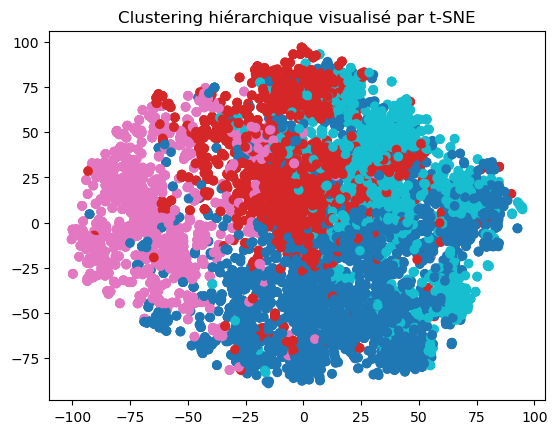

In [ ]:

tsne = TSNE(metric='cosine', n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)

plt.scatter(X_embedded[:,0], X_embedded[:,1], c=labels, cmap='coolwarm')
plt.title("Clustering hiérarchique visualisé par t-SNE")
plt.show()


In [ ]:

model = KMedoids(n_clusters=4, metric='cosine', random_state=42)  # Choisir le nombre de clusters

model.fit(X_scaled)  # X issu d'un TfidfVectorizer avec n-grams
labels = model.labels_


In [60]:
silhouette = silhouette_score(X_scaled, labels, metric='cosine')
print("Silhouette Score:", silhouette)

Silhouette Score: 0.10652141


In [68]:
labels

array([1, 1, 2, ..., 0, 0, 0], dtype=int64)

In [62]:
(labels==0).sum(), (labels==1).sum(), (labels==2).sum(), (labels==3).sum()

(3018, 1877, 2499, 1723)

In [ ]:
df[df["label"]=="Science"]["predict"].value_counts()

In [63]:

df1

,name,text,label,removed_text,clean_text,tokenized_text
2153,124146.txt,Nntp-Posting-Host: acvax1\nNntp-Posting-User: ...,Politics,nntp posting host acvax nntp posting user cvad...,nntp posting host acvax nntp posting user cvad...,"[nntp, posting, host, acvax, nntp, posting, us..."
2154,176845.txt,\nIn <C4v13w.Dup@apollo.hp.com> nelson_p@apoll...,Politics,peter nelson writes article bob blackshaw writ...,peter nelson writes article bob blackshaw writ...,"[peter, nelson, writes, article, bob, blacksha..."
2155,176846.txt,NNTP-Posting-Host: oregon.uoregon.edu\nNews-So...,Politics,nntp posting host oregon uoregon edu news soft...,nntp posting host oregon uoregon edu news soft...,"[nntp, posting, host, oregon, uoregon, edu, ne..."
2156,176847.txt,NNTP-Posting-Host: oregon.uoregon.edu\nNews-So...,Politics,nntp posting host oregon uoregon edu news soft...,nntp posting host oregon uoregon edu news soft...,"[nntp, posting, host, oregon, uoregon, edu, ne..."
2157,176849.txt,NNTP-Posting-Host: oregon.uoregon.edu\nNews-So...,Politics,nntp posting host oregon uoregon edu news soft...,nntp posting host oregon uoregon edu news soft...,"[nntp, posting, host, oregon, uoregon, edu, ne..."
...,...,...,...,...,...,...
9148,62615.txt,Distribution: world\nMessage-ID: <cshotton-180...,Science,distribution world message references nntp pos...,distribution world message reference nntp post...,"[distribution, world, message, reference, nntp..."
9149,62616.txt,\nJeffrey L. Cook sez;\n>>This object would no...,Science,jeffrey cook sez object would interfere anyone...,jeffrey cook sez object would interfere anyone...,"[jeffrey, cook, sez, object, would, interfere,..."
9150,62708.txt,Message-ID: <1tdqmvINN3q2@hp-col.col.hp.com>\n...,Science,message references nntp posting host hpctdkz c...,message reference nntp posting host hpctdkz co...,"[message, reference, nntp, posting, host, hpct..."
9151,62709.txt,Message-ID: <1t6dd1$11v@network.ucsd.edu>\nRef...,Science,message references nntp posting host lyapunov ...,message reference nntp posting host lyapunov u...,"[message, reference, nntp, posting, host, lyap..."


In [64]:
# Réduction en 3 dimensions
tsne = TSNE(n_components=3, random_state=42)
X_reduced_3d = tsne.fit_transform(X_scaled)

# Création du DataFrame pour plotly (optionnel mais pratique)
df_ = pd.DataFrame({
    'TSNE-1': X_reduced_3d[:, 0],
    'TSNE-2': X_reduced_3d[:, 1],
    'TSNE-3': X_reduced_3d[:, 2],
    'label': labels
})

# Visualisation 3D avec plotly
fig = px.scatter_3d(
    df_, x='TSNE-1', y='TSNE-2', z='TSNE-3',
    color='label',
    title='t-SNE 3D Visualization of Clusters',
    color_continuous_scale='Viridis'
)
fig.show()
